# The ARMA framework, part 2: Model selection

We will illustrate the usual "Box-Jenkins" approach to selecting an ARMA model for a given dataset, using GDP growth rate (seasonally adjusted) and S&P 500 index returns as examples.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from numpy.random import normal
import math

import wrds
import fredapi

from scipy.optimize import minimize

from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox as LjungBox

from matplotlib import pyplot as plt

import os
from dotenv import load_dotenv
load_dotenv();

# Example 1: GDP growth rate:

Imagine you want to model and forecast the GDP growth rate from one quarter to the next. To think about this exercise, let's download seasonally-adjusted quarterly GDP figures as in prior weeks.

- In practice you might prefer to forecast non-seasonally-adjusted figures. We will illustrate this in the last notebook for this section of the course, after covering how to adjust for seasonality in an ARMA framework.
- The raw data are in billions. We divide by $1,000 so the numbers are in trillions for visual ease and also because it helps with some calculations below.
- The raw data are also annualized rates (that is, they are multiplied by 4). We undo this to get to the raw numbers.


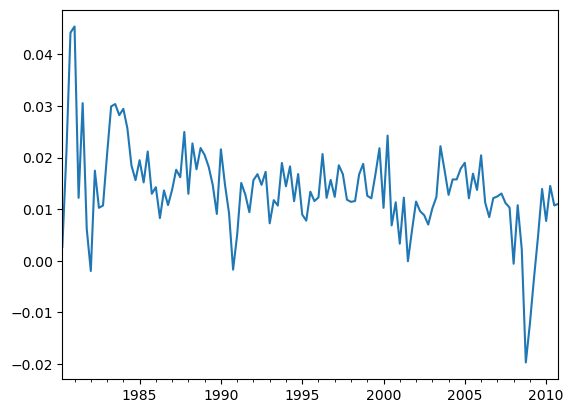

In [2]:
GDP = fredapi.Fred().get_series('GDP'  , observation_start = '1980-01-01', observation_end = '2010-12-31', frequency='q', aggregation_method = 'sum').resample('Q').first()
GDP = GDP / 1000
GDP = GDP / 4
GDP_growth = np.log(GDP).diff().dropna()
GDP_growth.plot();

Check that the series appear stationary

In [3]:
adfuller(GDP_growth)

(np.float64(-4.67243402785884),
 np.float64(9.478045843531165e-05),
 1,
 121,
 {'1%': np.float64(-3.485585145896754),
  '5%': np.float64(-2.885738566292665),
  '10%': np.float64(-2.5796759080663887)},
 np.float64(-817.6878305077834))

Now we follow the Box-Jenkins approach to model selection.

First, try a Ljung-Box test on the raw data. The low p-value tells us that there is some important time-series behavior that we want to capture. 

In [4]:
print("Ljung-Box test on GDP growth:")
print( LjungBox( GDP_growth , lags=1) )

Ljung-Box test on GDP growth:
     lb_stat     lb_pvalue
1  34.467459  4.334374e-09


To figure out what these patterns might be, we take a look at the ACF and PACF:

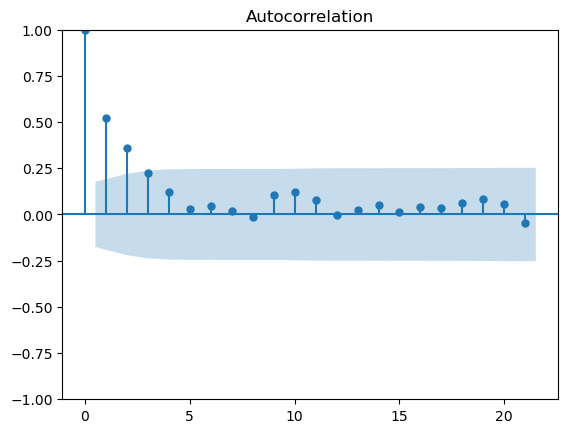

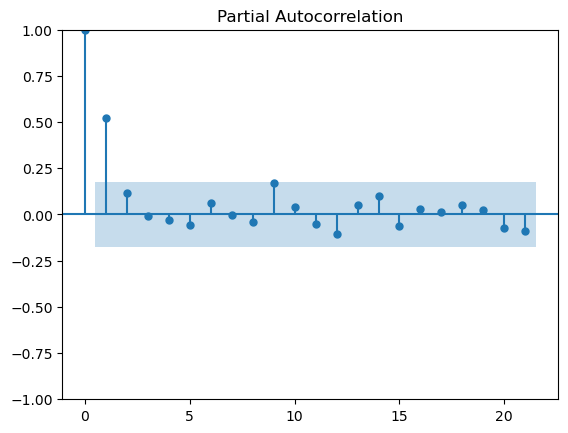

In [5]:
plot_acf(GDP_growth);
plot_pacf(GDP_growth);

The slowly-decaying ACF, and the cutoff after 1 lag in the PACF, suggest an AR(1) process, which is usually a natural first guess anyway. 

So next we fit an AR1 model, and plot the ACF and PACF of the residuals from this model. We don't see much evidence of anything left to model.

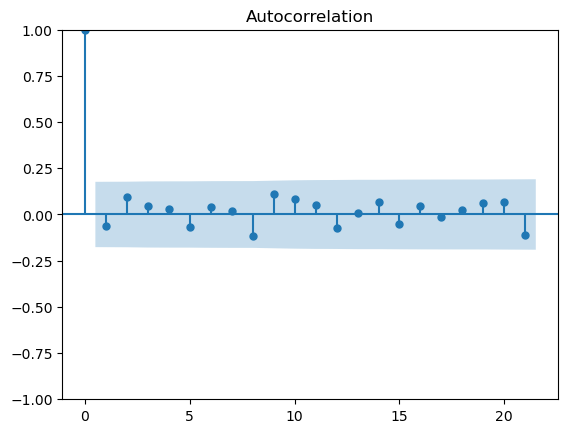

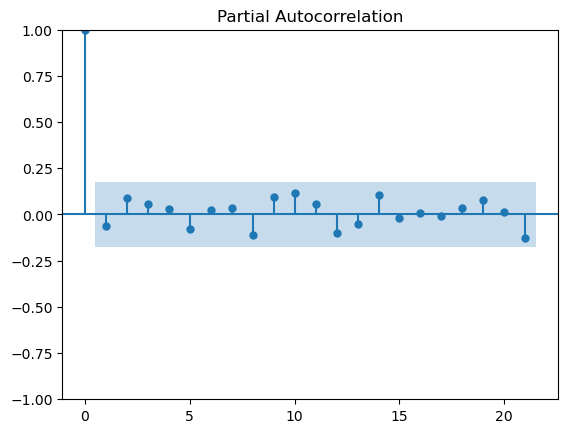

In [6]:
AR1_model = ARIMA(GDP_growth,order=(1,0,0)).fit()
plot_acf(AR1_model.resid);
plot_pacf(AR1_model.resid);

We test formally for any remaining time series patterns by applying the L-B test to the residuals from the AR1 model. 

(I will repeat that it would be better to do a Breusch-Godfrey test here, but that is not the standard practice.)

In [7]:
print("Ljung-Box test on residuals from AR1 model:")
print( LjungBox( AR1_model.resid , lags=1) )

Ljung-Box test on residuals from AR1 model:
    lb_stat  lb_pvalue
1  0.488659   0.484526


The p-value of the test now comes out large. We therefore fail to reject the null hypothesis that the residuals have zero autocorrelation (at order 1), and we conclude that there's nothing more to add to the model. Then we can proceed doing any analysis that assumes uncorrelated residuals, such as building prediction intervals for our forecasts. We will resume this example and do that analysis in the next notebook.

# Example 2: Monthly S&P 500 returns

In [8]:
wrds_conn = wrds.Connection(wrds_username=os.environ['WRDS_USERNAME'])

spindx = wrds_conn.raw_sql("select caldt, spindx from crsp_a_indexes.msp500")
spindx['month'] = pd.to_datetime(spindx['caldt']).dt.to_period('M')
spindx = spindx.set_index(['month']).drop('caldt',axis=1)
spindx = spindx['1980-01':'2010-12']

ret = spindx.diff()/spindx.shift()
ret = ret.dropna()

Loading library list...
Done


First, let's just plot monthly S&P 500 returns, and their ACF and PACF. 

As we might expect, these show no clear time-series patterns.

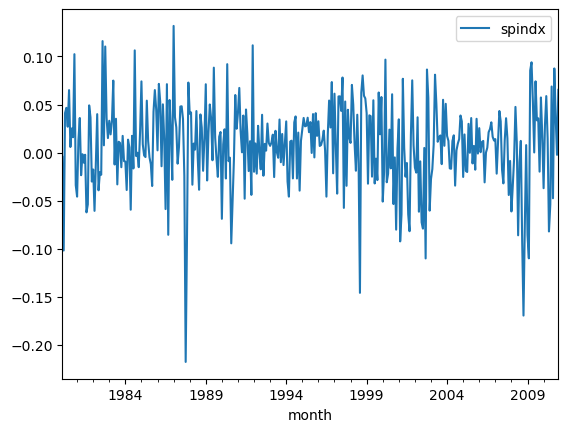

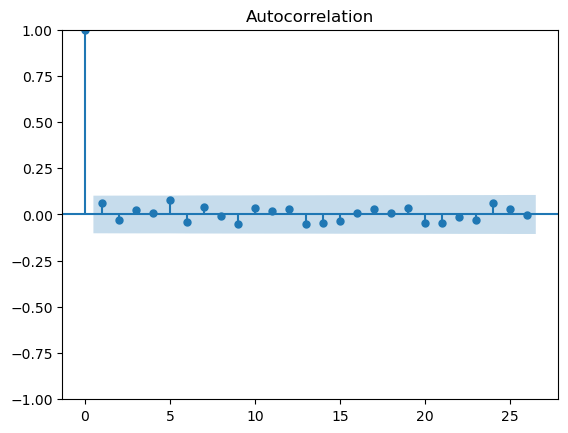

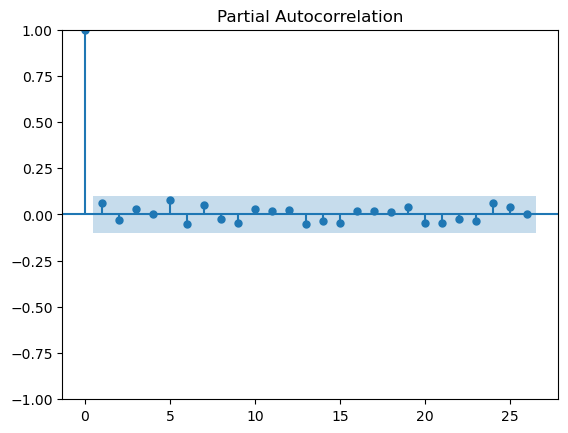

In [9]:
ret.plot();
plot_acf(ret);
plot_pacf(ret);

Consistent with this, the Ljung-Box test applied to the raw data already tell us that there are no detectable time-series effects.

In [10]:
print( LjungBox(ret,lags=1) )

    lb_stat  lb_pvalue
1  1.365425   0.242599


We conclude that there is no real model selection to be done. Any modeling we want to do with this series would be valid.

But, we can use this data to illustrate some time-series patterns (specifically, MA patterns) that can arise mechanically in practice due to transformations of the data, rather than any economics of the data.

**Overlapping windows:** First, suppose we were analyzing a dataset that reported, for each month, the S&P 500 index return over the previous *three* months. For example, in March the dataset reports the return from December through March, in April the return from January through April, etc. Between any pair of months data, there will be two months of overlapping returns. This will create a mechanical kind of MA pattern in our data.

Let's spell this out in more detail theoretically:

- Label the one-month log S&P returns as $r_t = ln(SP500_t) - ln(SP500_{t-1})$. 
- Label the three-month return as $r_{3,t} = ln(SP500_t) - ln(SP500_{t-3})$. 
- Then we can say that $r_{3,t} = r_t + r_{t-1} + r_{t-2}$.
- Assume that each month's $r_t$ is a random draw from some distribution, with no correlation from month to month, which appears reasonable based on the figures above.
- Then $r_{3,t}$ follows an MA(2) process with $\mu=0$, and $\theta_1 = \theta_2 = 1$.

Examine the 3-month return series for evidence of this pattern: Indeed, it resembles an MA process of order 2.

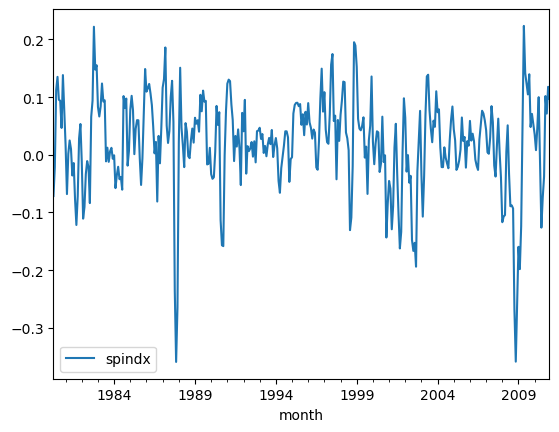

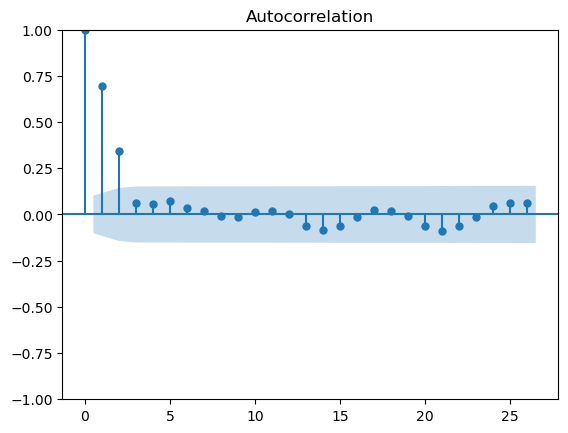

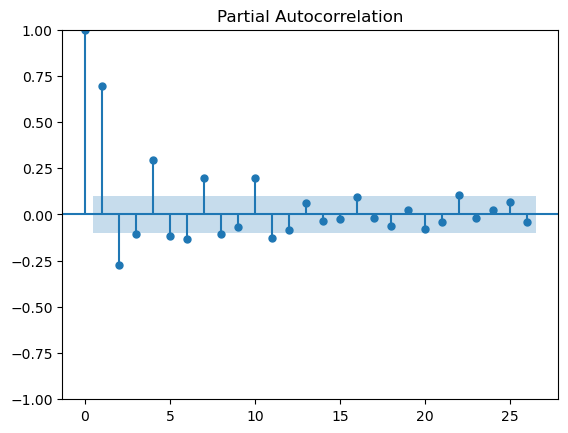

In [11]:
ret3 = np.log(spindx).diff(3).dropna()
ret3.plot();
plot_acf(ret3);
plot_pacf(ret3);

Fit the model and check that the residuals don't appear to have any remaining time-series pattern.

                               SARIMAX Results                                
Dep. Variable:                 spindx   No. Observations:                  369
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 612.182
Date:                Thu, 01 Jan 2026   AIC                          -1216.364
Time:                        14:23:41   BIC                          -1200.721
Sample:                    04-30-1980   HQIC                         -1210.150
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.008      2.480      0.013       0.004       0.035
ma.L1          1.0160      2.693      0.377      0.706      -4.262       6.294
ma.L2          1.0000      5.299      0.189      0.8

/home/william/miniforge3/envs/FIN657/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


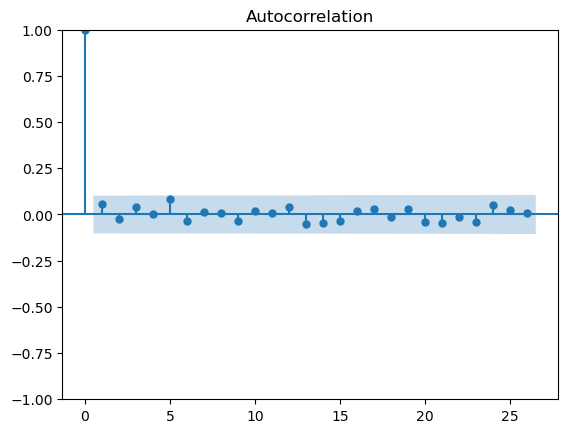

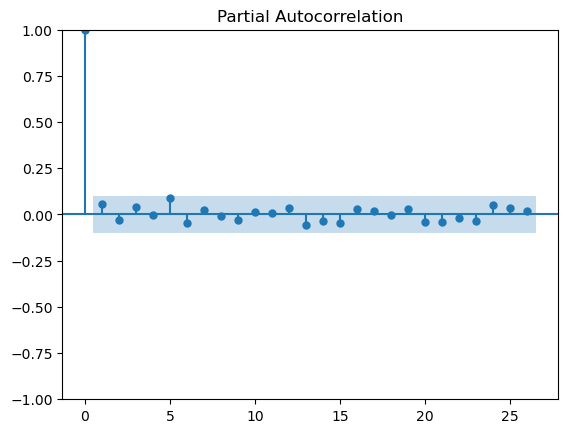

In [12]:
MLE_results = ARIMA(ret3,order=(0,0,2),freq='M').fit()
print(MLE_results.summary() )
plot_acf( MLE_results.resid );
plot_pacf( MLE_results.resid);

Conclusion: Overlapping data can create MA patterns. What to do about this? If you can build the data yourself, probably best to avoid ending up with overlapping windows like this. If someone gives you the data, you could analyze at a quarterly frequency, but if you really need to analyze monthly, it's just a matter of taking into account the MA terms when modeling the process.

**Overdifferencing**:
A similar effect happens when you *overdifference* data, that is, when you difference a series that is already stationary. This will tend to create an MA(1) pattern in the differenced series. 

For example, suppose your process is $y_t = \mu + u_t$, which is stationary.
Then $\Delta y_t = u_t - u_{t-1}$, an MA(1) process. To illustrate, in the code below, we start with one-month returns (which are already stationary), and then difference them.
Indeed, we see patterns that look like MA(1).

     lb_stat     lb_pvalue
1  76.271729  2.471976e-18


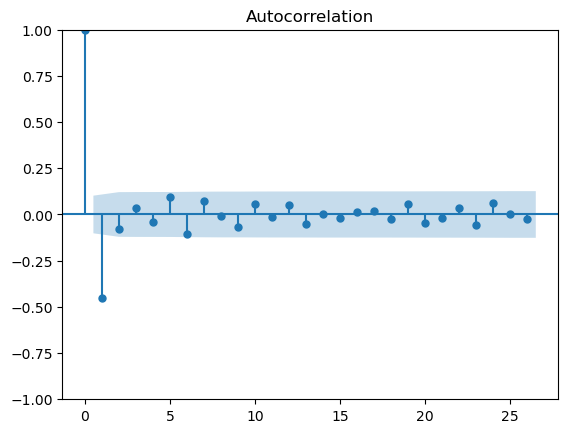

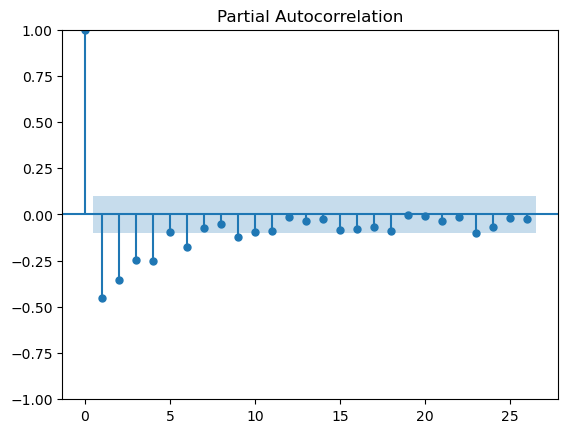

In [13]:
# Raw monthly returns are stationary, but the differenced series has a clear MA1 component
print( LjungBox( ret.diff().dropna() , lags=1) )
plot_acf( ret.diff().dropna() );
plot_pacf( ret.diff().dropna() );

Be careful about overdifferencing! Many people have a tendency to difference data whenever they have any suspicion at all that the data might not be stationary. But this is not a good rule! It feels like "being safe," but it may actually introduce more problems than it solves.
Here, we have illustrated that overdifferencing will introduce extra MA terms into your process.
You can account for this when modeling the process, but there's no need to be in this situation in the first place because the process was already stationary before differencing!
In fact, there are bigger and deeper problems beyond this specific one, that are beyond the scope of the current course to illustrate.

Conclusion: 
Instead of differencing aggressively,
it's better to think about what seems reasonable from economic understanding of the series.
If you don't have a strong reason to think the series is nonstationary, then it's better *not* to difference,
even if the statistical tests for stationary behavior are borderline.

But if someone hands you data that has already been overdifferenced, and you have no choice but to deal with it, then the best approach is to fit the MA(1) component, check that the residuals from this again have no clear patterns, and then proceed with the analysis as normal. This is illustrated below.

   lb_stat  lb_pvalue
1  1.10904   0.292291


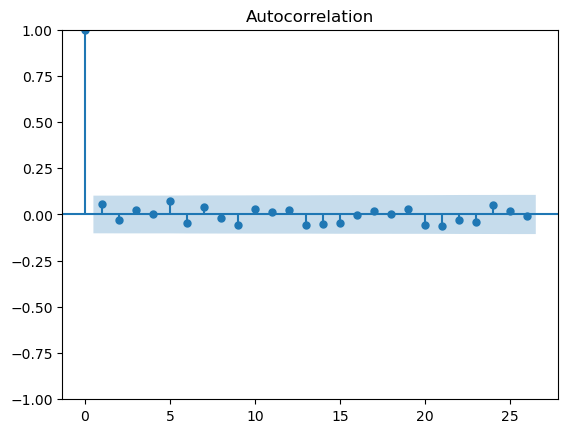

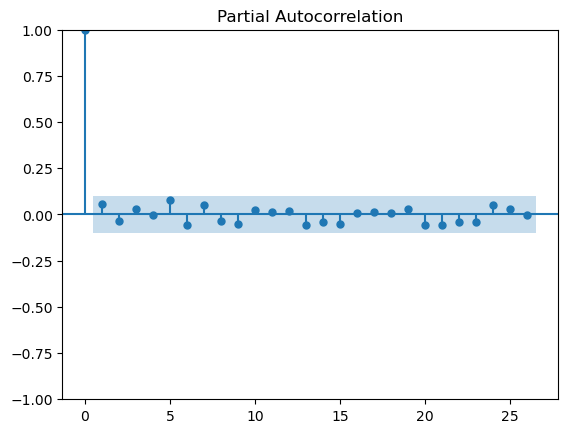

In [14]:
# If we fit an MA(1) to the differenced return series, then the residuals again display no time-series patterns
MA_results = ARIMA( ret.diff().dropna(), order = (0,0,1) ).fit()
print( LjungBox( MA_results.resid , lags=1) )
plot_acf( MA_results.resid );
plot_pacf( MA_results.resid );